In [51]:
import pandas as pd
import re

# Load data
df_kabinetten = pd.read_csv('kabinetten.csv')

# Dutch dates to a standardised format

def parse_nl_date(date_str):
    try:
        months = {
            'januari': '01', 'februari': '02', 'maart': '03', 'april': '04',
            'mei': '05', 'juni': '06', 'juli': '07', 'augustus': '08', 'september': '09',
            'oktober': '10', 'november': '11', 'december': '12'
        }

        day, month, year = re.split(r'\s+', date_str.strip())
        month_num = months[month.lower()]
        date_formatted = f'{year}-{month_num}-{day.zfill(2)}'
        return pd.to_datetime(date_formatted, errors='coerce')
    except:
        return pd.NaT

# Convert dates to datetime
df_kabinetten['Aantreden'] = df_kabinetten['Aantreden'].apply(parse_nl_date)
df_kabinetten['Verkiezing'] = df_kabinetten['Verkiezing'].apply(parse_nl_date)
df_kabinetten['Aftreden'] = df_kabinetten['Aftreden'].apply(parse_nl_date)

# Only from 1918 onwards, as that is when the Dutch constitution was changed
df_kabinetten = df_kabinetten[df_kabinetten['Aantreden'].dt.year >= 1918]

# Cleaned data
df_kabinetten.to_csv('kabinetten_schoongemaakt.csv', index=False)

print("Data is cleaned and saved in 'kabinetten_schoongemaakt.csv'.")


Data is cleaned and saved in 'kabinetten_schoongemaakt.csv'.


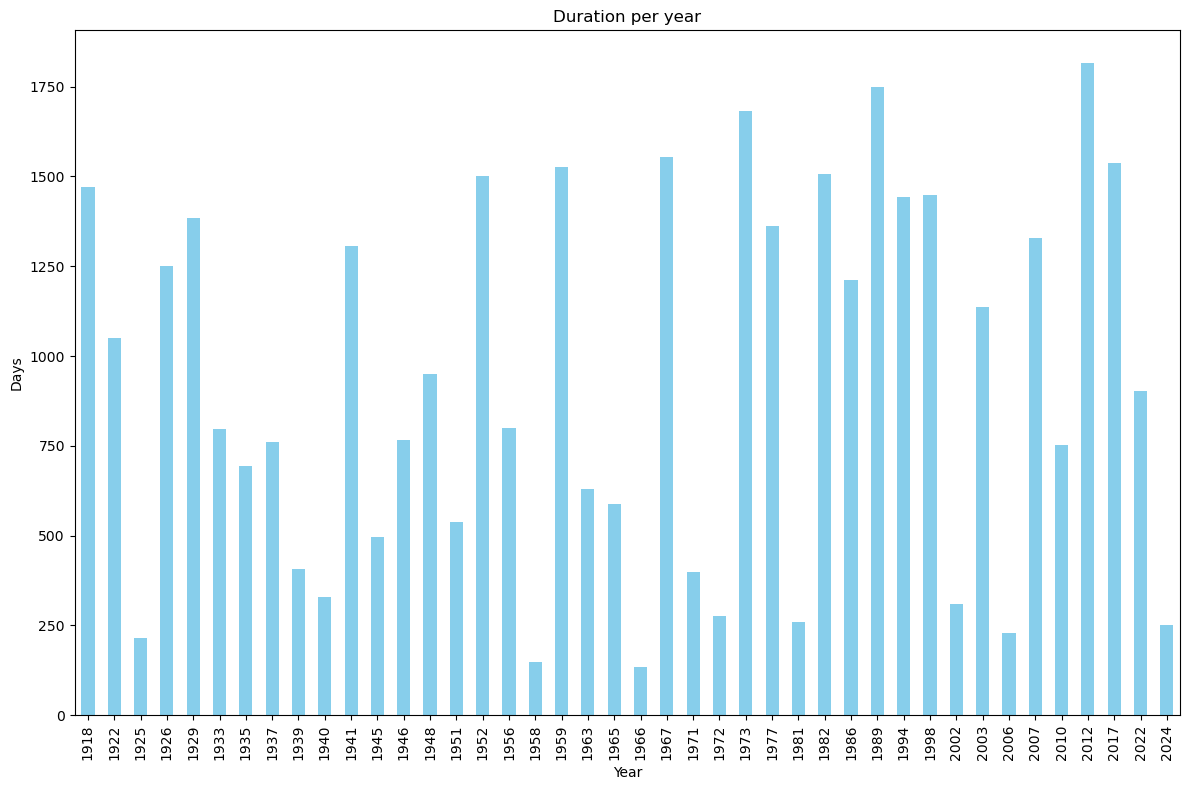

In [52]:
import matplotlib.pyplot as plt

# Load data
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# analyse cabinet length
df_kabinets_duur = df_kabinetten.groupby(df_kabinetten['Aantreden'].str[:4].astype(int))['Dagen'].sum()

# Trends in cabinet length
plt.figure(figsize=(12, 8))
df_kabinets_duur.plot(kind='bar', color='skyblue')
plt.ylabel('Days')
plt.xlabel('Year')
plt.title('Duration per year')
plt.tight_layout()
plt.show()


Accuracy: 0.7777777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.78      1.00      0.88         7

    accuracy                           0.78         9
   macro avg       0.39      0.50      0.44         9
weighted avg       0.60      0.78      0.68         9

Confusion Matrix:


/home/merijn/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/merijn/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/merijn/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


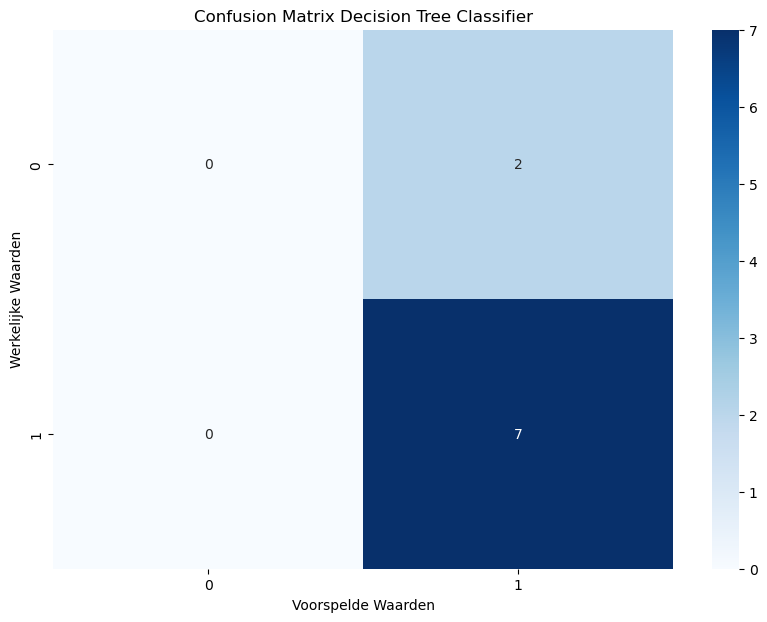

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Convert datetime to columns to timedelta from a reference point, if not done
ref_date = pd.Timestamp('1918-01-01')
df_kabinetten['Verkiezing'] = (pd.to_datetime(df_kabinetten['Verkiezing']) - ref_date).dt.days
df_kabinetten['Aantreden'] = (pd.to_datetime(df_kabinetten['Aantreden']) - ref_date).dt.days

# Select relevant columns and one-hot encoding for 'Partijen'
X = pd.concat([df_kabinetten[['Verkiezing', 'Aantreden']], pd.get_dummies(df_kabinetten['Partijen'])], axis=1)

# Target column (Days)
y = df_kabinetten['Dagen']

# Binary classification for 'Dagen' > 365
y_binary = y.apply(lambda x: 1 if x > 365 else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5)  # max_depth kan worden aangepast voor beter resultaat
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Voorspelde Waarden')
plt.ylabel('Werkelijke Waarden')
plt.title('Confusion Matrix Decision Tree Classifier')
plt.show()


Class distribution in the target variable:
Dagen
1    33
0    12
Name: count, dtype: int64
Train set size: 36
Test set size: 9
Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.86      0.80         7

    accuracy                           0.67         9
   macro avg       0.38      0.43      0.40         9
weighted avg       0.58      0.67      0.62         9

Confusion Matrix:


/tmp/ipykernel_14969/4252331397.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
/tmp/ipykernel_14969/4252331397.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

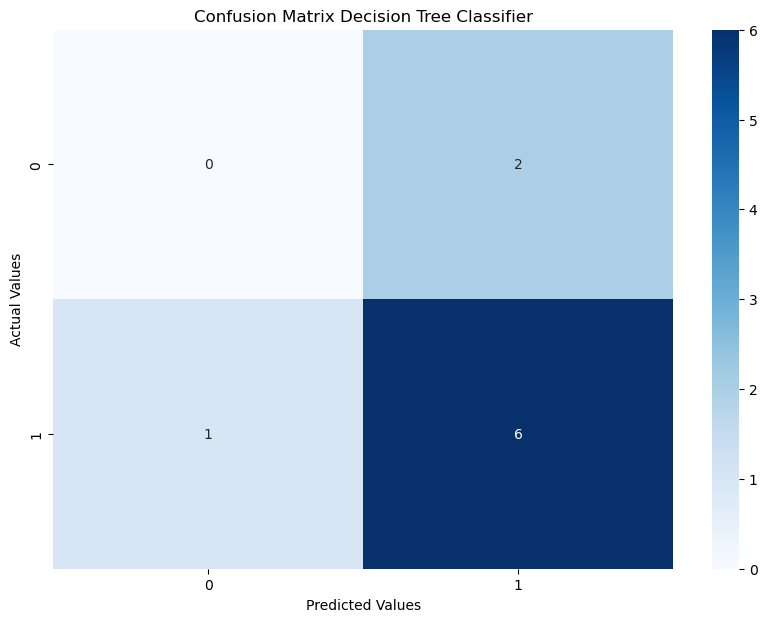

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Read data
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Convert datetime columns to time deltas from a reference point '1918-01-01'
ref_date = pd.Timestamp('1918-01-01')
df_kabinetten['Verkiezing'] = pd.to_datetime(df_kabinetten['Verkiezing'], errors='coerce')
df_kabinetten['Aantreden'] = pd.to_datetime(df_kabinetten['Aantreden'], errors='coerce')

# Fill missing date values in 'Verkiezing' and 'Aantreden' with a default year
default_date = ref_date + pd.DateOffset(years=1)  # Add one year to ref_date as default
df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
df_kabinetten['Aantreden'].fillna(default_date, inplace=True)

# Convert datetime columns to time deltas from the reference point
df_kabinetten['Verkiezing'] = (df_kabinetten['Verkiezing'] - ref_date).dt.days
df_kabinetten['Aantreden'] = (df_kabinetten['Aantreden'] - ref_date).dt.days

# Process the 'Partijen' column to split multiple parties and encode them
def split_and_rename_parties(df):
    df_parties_expanded = df['Partijen'].str.get_dummies(sep=',')
    df_combined = pd.concat([df.drop(['Partijen'], axis=1), df_parties_expanded], axis=1)
    return df_combined

df_kabinetten_expanded = split_and_rename_parties(df_kabinetten)

# Select relevant columns
X = df_kabinetten_expanded.drop(['Kabinet', 'Foto', 'Minister-president', 'Demissionair', 'Aftreden', 'Dagen'], axis=1)
y = df_kabinetten_expanded['Dagen']

# Fill missing values in the feature matrix with the median (or another suitable strategy)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Binary classification
y_binary = y.apply(lambda x: 1 if x > 365 else 0)

# Check class distribution
print("Class distribution in the target variable:")
print(y_binary.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Check size of the training and test sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

# SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_res, y_train_res)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix Decision Tree Classifier')
plt.show()


In [55]:
import pandas as pd

# Read data
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Convert 'Dagen' to numeric values if needed
df_kabinetten['Dagen'] = df_kabinetten['Dagen'].apply(pd.to_numeric, errors='coerce')

# Filter cabinets that lasted less than a year (365 days)
df_short_term = df_kabinetten[df_kabinetten['Dagen'] <= 365]

# Print information about cabinets that lasted less than a year
print("Cabinets that lasted less than a year:")
print("\n")
print(df_short_term[['Kabinet', 'Minister-president', 'Partijen', 'Aantreden', 'Aftreden', 'Dagen']])


Cabinets that lasted less than a year:


           Kabinet          Minister-president                   Partijen  \
2         Colijn I      Hendrikus Colijn (ARP)             RKSP, ARP, CHU   
8         Colijn V            Hendrikus Colijn              ARP, CHU, LSP   
10     Gerbrandy I      Pieter Gerbrandy (ARP)  RKSP, SDAP, ARP, CHU, VDB   
12   Gerbrandy III      Pieter Gerbrandy (ARP)             RKSP, ARP, VDB   
19         Beel II            Louis Beel (KVP)              KVP, ARP, CHU   
23        Zijlstra        Jelle Zijlstra (ARP)                   KVP, ARP   
26   Biesheuvel II     Barend Biesheuvel (ARP)         KVP, VVD, ARP, CHU   
29      Van Agt II         Dries van Agt (CDA)            CDA, PvdA, D'66   
30     Van Agt III         Dries van Agt (CDA)                  CDA, D'66   
36    Balkenende I  Jan Peter Balkenende (CDA)              CDA, LPF, VVD   
38  Balkenende III  Jan Peter Balkenende (CDA)                   CDA, VVD   
44          Schoof    Dick Schoof (

Column types in the DataFrame:
Kabinet                       object
Foto                         float64
Minister-president            object
Partijen                      object
Zetelverdeling               float64
Verkiezing            datetime64[ns]
Aantreden             datetime64[ns]
Demissionair                  object
Aftreden                      object
Dagen                          int64
Verkiezingsjaar                int32
Aantredingsjaar                int32
Majority                       int64
dtype: object
Accuracy: 0.5555555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      0.71      0.71         7

    accuracy                           0.56         9
   macro avg       0.36      0.36      0.36         9
weighted avg       0.56      0.56      0.56         9

Confusion Matrix:


/tmp/ipykernel_14969/4233359861.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
/tmp/ipykernel_14969/4233359861.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

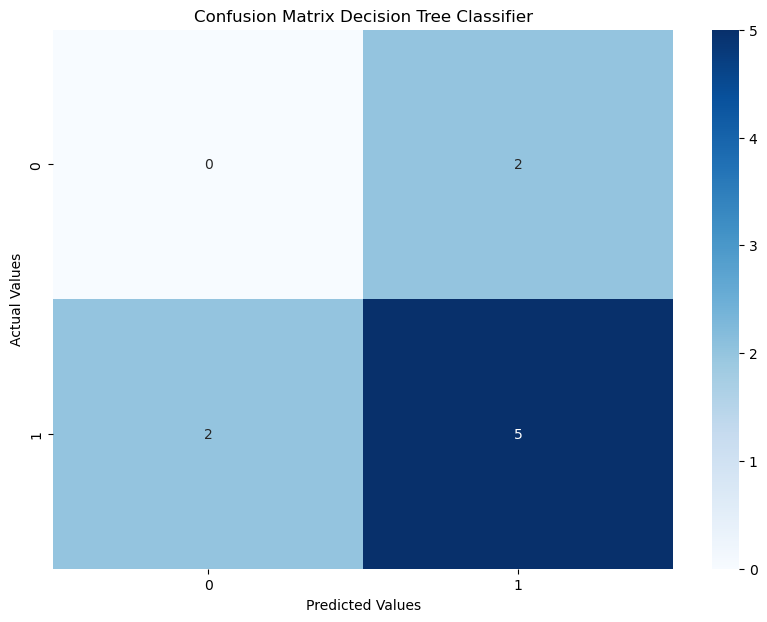

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Read data for cabinets
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Convert date columns to datetime objects
df_kabinetten['Verkiezing'] = pd.to_datetime(df_kabinetten['Verkiezing'], errors='coerce')
df_kabinetten['Aantreden'] = pd.to_datetime(df_kabinetten['Aantreden'], errors='coerce')

# Fill missing date values in 'Verkiezing' and 'Aantreden' with a default year
default_date = pd.Timestamp('1919-01-01')
df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
df_kabinetten['Aantreden'].fillna(default_date, inplace=True)

# Convert date columns to years
df_kabinetten['Verkiezingsjaar'] = df_kabinetten['Verkiezing'].dt.year
df_kabinetten['Aantredingsjaar'] = df_kabinetten['Aantreden'].dt.year

# Read data for seat distribution
df_zetels_100 = pd.read_csv('../zetelverdeling/zetel-data/tk_zetels100_1918-1956.csv')
df_zetels_150 = pd.read_csv('../zetelverdeling/zetel-data/tk_zetels150_1956-2023.csv')

# Combine both seat distribution datasets
df_zetels = pd.concat([df_zetels_100, df_zetels_150], ignore_index=True)

# Convert seat distribution data to a pivot table with years as index
df_zetels_pivot = df_zetels.pivot_table(index='Jaar', columns='Partij', values='Zetels', aggfunc='sum').fillna(0)

# Determine majority seats for cabinets, with error handling for missing years
def check_majority(df_kabinet, df_zetelspivot):
    majority_list = []
    for index, row in df_kabinet.iterrows():
        election_year = row['Verkiezingsjaar']
        cabinet_parties = row['Partijen'].split(',')
        party_seats = 0
        if election_year in df_zetelspivot.index:
            party_seats = df_zetelspivot.loc[election_year, cabinet_parties].sum()
            if election_year <= 1956:
                if party_seats > 50:  # Majority seats pre-1956
                    majority_list.append(1)
                else:
                    majority_list.append(0)
            else:
                if party_seats > 75:  # Majority seats post-1956
                    majority_list.append(1)
                else:
                    majority_list.append(0)
        else:
            majority_list.append(0)  # Assume no majority if year is missing
    return majority_list

df_kabinetten['Majority'] = check_majority(df_kabinetten, df_zetels_pivot)

# Inspect DataFrame for non-numeric columns
print("Column types in the DataFrame:")
print(df_kabinetten.dtypes)

# Process and one-hot encode the 'Partijen' column
def split_and_rename_parties(df):
    df_parties_expanded = df['Partijen'].str.get_dummies(sep=',')
    df_combined = pd.concat([df.drop(['Partijen'], axis=1), df_parties_expanded], axis=1)
    return df_combined

df_kabinetten_expanded = split_and_rename_parties(df_kabinetten)

# Create Feature Matrix and Target Variable
X = df_kabinetten_expanded.drop(['Kabinet', 'Foto', 'Minister-president', 'Demissionair', 'Aftreden', 'Dagen'], axis=1)
y = df_kabinetten_expanded['Dagen']

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values in the feature matrix with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Binary classification for target variable
y_binary = y.apply(lambda x: 1 if x > 365 else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Oversampling with SMOTE to improve data balance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix Decision Tree Classifier')
plt.show()
